# Submission files

- [x] [model python code]()
- [x] [drive.py]()
- [x] [keras trained model]()
- [x] [writeup(this file)]()

# Abstract
This project uses Keras (Tensorflow backend) to implement a deep convolutional neuron network based NVIDIA's paper [End to End Learning for Self-Driving Cars](https://arxiv.org/abs/1604.07316) and apply this deep-learning based autonomous driving technique in a simlulator. 

# Data aquisition

Data for training were recorded using the provided simulator. A human driver using a joystick drives the car on track1 in the simulator, which records real-time telemetry data of the steering input, throttle, speed and a stream of three images captured by the three front-facing cameras (left, center, right) attached to the car. At the end, a `csv` log file is generated mapping telemetry data to image files and a folder containing the images. 

The car was driven by a human driver on track1 for about 1 hour, and on a mountain track for about 20 min. 

The version 1 simulator is used for data collection.

## Raw data visualization

* samples of images:


In [1]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import cv2
from PIL import Image
import numpy as np


def read_img(path):
    """
    Returns a numpy array image from path
    """
    img = cv2.imread(path.strip())
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


def load_img(path):
    image = Image.open(path)
    image = image.convert('RGB')
    return image


def preprocess_data(data):
    """
    Return processed data
    """
    return data['center'], data['steering']


def images_to_nparray(image_list, w=160, h=320):
    output = []
    for image in image_list:
        img = np.array(list(image.getdata()), dtype='uint8')
        img = np.reshape(img, (w, h, 3))
        output.append(img)

    return np.array(output, dtype='uint8')


def get_batch(data, batch_size=24*6):
    batch = data.sample(int(batch_size/6))
    img_paths = np.concatenate((batch['center'].str.strip().values,
                               batch['center_flipped'].str.strip().values,
                               batch['left'].str.strip().values,
                               batch['left_flipped'].str.strip().values,
                               batch['right'].str.strip().values,
                               batch['right_flipped'].str.strip().values))
    steerings = np.concatenate((batch['center_steering'].values,
                               batch['center_steering_flip'].values,
                               batch['left_steering'].values,
                               batch['left_steering_flip'].values,
                               batch['right_steering'].values,
                               batch['right_steering_flip'].values))
    img_list = []
    for path in img_paths:
        img = load_img(path)
        img = np.asarray(img, dtype='float32')
        img_list.append(img)

    imgs = np.array(img_list, dtype='float32')
    strs = np.array(steerings, dtype='float32')

    return imgs, strs


def train_sample_generator(train_df, batch_size=24*6):
    """
    Generate a batch of training data
    """
    while True:
        yield get_batch(train_df, batch_size=batch_size)


def valid_sample_generator(valid_df, batch_size_valid=24*6):
    return train_sample_generator(valid_df, batch_size_valid)


def crop_imgs(imgs, top=60, bottom=140):
    """
    Returns croppped image tensor
    """
    return imgs[:,top:bottom,:,:]



In [3]:
csv_filename = 'driving_log.csv'
data_path = "../sim_data/data/"

data_csv_path = data_path + csv_filename

data_csv_df = pd.read_csv(data_csv_path, index_col=False)

data_csv_df.columns = ['center', 'left', 'right', 'center_steering', 'throttle', 'brake', 'speed']
sample = data_csv_df.sample(n=1)

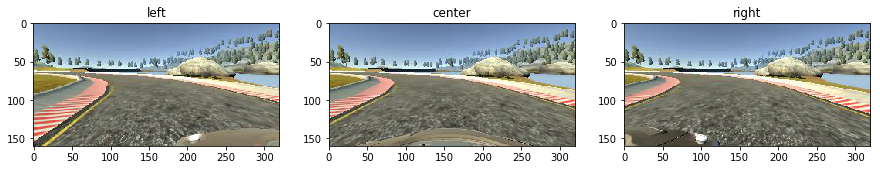

In [5]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)

for i, idx in enumerate(['left','center','right']):
    plt.subplot(1, 3, i+1)
    path = sample[idx].iloc[0].strip()
    img = load_img(path)
    plt.imshow(img)
    plt.title(idx)

* steering angle distribution:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc49bcdda58>]], dtype=object)

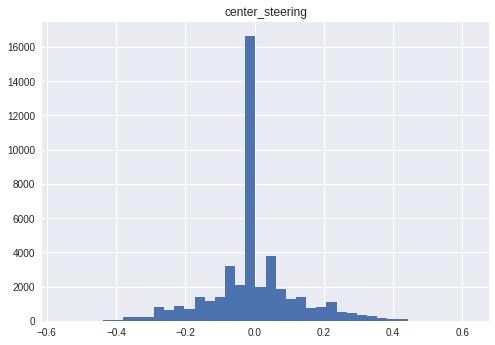

In [10]:
plt.style.use('seaborn')

data_csv_df.hist(column='center_steering', bins=40)

## Data augmentation
As we can see, the raw data of the steering has a strong bias to 0.0, i.e. straight driving. To improve the training for turning, we need to augment the raw data. Here I choose the following augmentation techniques, in the sequence of data processing:
* randomly drop 0.0 steering data (with a probability of 0.7) to reduce straight-driving bias.
* use all three camera views:
    * the left and right camera views will have corresponding steering angles that are artificially shifted from the steering angles recorded, which are assigned to the center camera view. The shifting magnitude is `1.5xstandard deviation` of the original steering angles.
* all three cameras images are duplicated as horizontally-mirrored ones and their corresponding steering angles inversed, which results in a two-times-larger dataset.
    
### here is some visualizations of this augmented dataset

In [4]:
aug_csv_filename = 'driving_log_aug.csv'
aug_data_path = "../sim_data/data/"

aug_data_csv_path = aug_data_path + aug_csv_filename

aug_data_csv_df = pd.read_csv(aug_data_csv_path, index_col=False)

aug_sample = aug_data_csv_df.sample(n=1)


* augmented camera views:

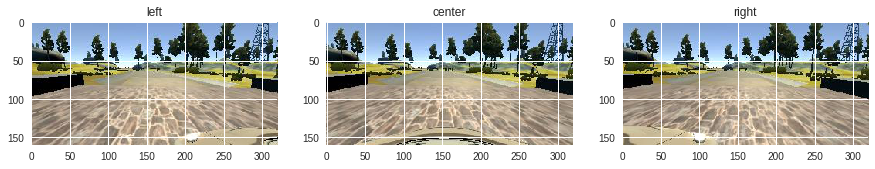

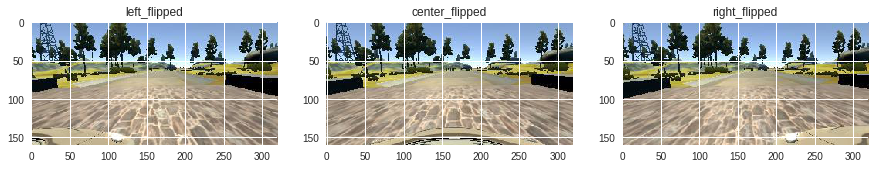

In [19]:
plt.figure(figsize=(15,10))

for i, idx in enumerate(['left', 'center', 'right']):
    plt.subplot(1, 3, i+1)
    path = aug_sample[idx].iloc[0].strip()
    img = load_img(path)
    plt.imshow(img)
    plt.title(idx)

plt.figure(figsize=(15,10))
for i, idx in enumerate(['left_flipped', 'center_flipped', 'right_flipped']):
    plt.subplot(1, 3, i+1)
    path = aug_sample[idx].iloc[0].strip()
    img = load_img(path)
    plt.imshow(img)
    plt.title(idx)

* augmented steering angle distribution:

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc496f43748>]], dtype=object)

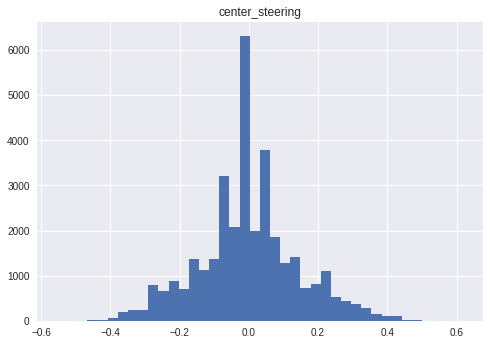

In [20]:
aug_data_csv_df.hist(column='center_steering', bins=40)

# Convolutional Neron Network architecture

In [2]:
from keras.utils import plot_model
import keras

model_file = './nvidia_net_wAugData.h5'
model_nv = keras.models.load_model(model_file)
plot_model(model_nv, to_file='model_nv.png', show_shapes=True)

![model](FIGS/model_nv.png)

* The fisrt Lambda layer is fro cropping images to retain only the center portion of the road lanes. The second Lambda layer normalizes the tensor.

* Comparing to NVIDIA's model, my model uses 4 instead of 5 Convolutional layers and a smaller (500 neurons instead of 1164) first fully-connected layer.

* This model has about 1.8M trainable parameters and it can be trained on an old GTX690 for about 10 min.

# Traing and tuning

The training dataset was split into 25% validation, 5% testing and 75% training segments.

For an old GTX690 to handle the training, I used a bach_size of 144, Epochs of 5 and a fixed learning_rate of 0.001. This model was further tuned using a fixed learning_rate of 0.0005 and Epochs of 3. The validation loss is about 1% for the final model.

# Test drive

![test_drive](FIGS/test_drive2.gif)

The car can drive at full speed (30MPH) on track 1 with no problem. However, it cannot drive on other tracks for longer than a few tens of seconds. This is due to the fact that the training dataset is so specific and the track used for training is relatively short; we do not have enough data for the car to generalize for other types of terrains. Generalization can be done using transfer learning techniques and fine-tuned using more data, which is left for future improvements.



[YouTube HD](https://www.youtube.com/watch?v=9kh1K6wM3sk)